In [1]:
%pip install poutyne # to install lastest poutyne if it's not already
import math
import os
import tarfile
import urllib.request
from shutil import copyfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils import model_zoo
from torchvision import transforms
from torchvision.datasets import ImageFolder

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger

Also, we need to set Pythons's, NumPy's and PyTorch's seeds by using Poutyne function so that our training is (almost) reproducible.

In [2]:
set_seeds(42)

In [3]:
def download_and_extract_dataset(path):
    tgz_filename = "images.tgz"
    urllib.request.urlretrieve("https://graal.ift.ulaval.ca/public/CUB200.tgz", tgz_filename)
    os.makedirs(path, exist_ok=True)
    archive = tarfile.open(tgz_filename)
    archive.extractall(path)

In [4]:
def copy(source_path, filenames, dest_path):
    for filename in filenames:
        source = os.path.join(source_path, filename)
        dest = os.path.join(dest_path, filename)
        copyfile(source, dest)

def split_train_valid_test(dataset_path, train_path, valid_path, test_path, train_split=0.6, valid_split=0.2): # test_split=0.2
    for classname in sorted(os.listdir(dataset_path)):
        if classname.startswith('.'):
            continue
        train_class_path = os.path.join(train_path, classname)
        valid_class_path = os.path.join(valid_path, classname)
        test_class_path = os.path.join(test_path, classname)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        dataset_class_path = os.path.join(dataset_path, classname)
        filenames = sorted(filename for filename in os.listdir(dataset_class_path) if not filename.startswith('.'))
        np.random.shuffle(filenames)

        num_examples = len(filenames)
        train_last_idx = math.ceil(num_examples*train_split)
        valid_last_idx = train_last_idx + math.floor(num_examples*valid_split)
        train_filenames = filenames[0:train_last_idx]
        valid_filenames = filenames[train_last_idx:valid_last_idx]
        test_filenames = filenames[valid_last_idx:]
        copy(dataset_class_path, train_filenames, train_class_path)
        copy(dataset_class_path, valid_filenames, valid_class_path)
        copy(dataset_class_path, test_filenames, test_class_path)

We do the split train/valid/test.

In [5]:
base_path = './CUB200'
dataset_path = os.path.join(base_path, 'images')
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

In [6]:
download_and_extract_dataset(base_path)
split_train_valid_test(dataset_path, train_path, valid_path, test_path)

Now, let's set our training constants. We first have the CUDA device used for training if one is present. Secondly, we set the number of classes (i.e. one for each number). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the number of epochs (i.e. the number of times we see the full dataset).


In [7]:
# Training constants
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

num_classes = 200
batch_size = 64
learning_rate = 0.1
n_epoch = 30

Creation of the PyTorch's datasets for our problem.

In [8]:
norm_coefs = {}
norm_coefs['cub200'] = [(0.47421962,  0.4914721 ,  0.42382449), (0.22846779,  0.22387765,  0.26495799)]
norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_coefs['cub200'])
])

train_set = ImageFolder(train_path, transform=transform)
valid_set = ImageFolder(valid_path, transform=transform)
test_set = ImageFolder(test_path, transform=transform)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

We load a pretrained `ResNet-18` networks and replace the head with the number of neurons equal to our number of classes.

In [9]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)


We freeze the network except for its head.

In [10]:
def freeze_weights(resnet18):
    for name, param in resnet18.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(resnet18)

We define callbacks for saving last epoch, best epoch and logging the results.

In [11]:
callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint('last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint('best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True,
                    restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),

    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger('log.tsv', separator='\t'),
]


Finally, we start the training and output its final test loss, accuracy, and micro F1-score.

> Note that the F1-score is quite similar to the accuracy since the dataset is very balanced.

In [12]:
optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

model = Model(resnet18, optimizer, loss_function, batch_metrics=['accuracy'], epoch_metrics=['f1'])

model.to(device)

model.fit_generator(train_loader, valid_loader, epochs=n_epoch, callbacks=callbacks)

test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}\n\tF1-score: {}'.format(test_loss, test_acc, test_f1))

Epoch: 1/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 4.961356 acc: 4.622871 fscore_micro: 0.046229 val_loss: 4.311240 val_acc: 9.646018 val_fscore_micro: 0.096460
Epoch 1: val_acc improved from -inf to 9.64602, saving file to best_epoch_1.ckpt
Epoch: 2/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 3.695623 acc: 24.763450 fscore_micro: 0.247635 val_loss: 3.564541 val_acc: 26.548673 val_fscore_micro: 0.265487
Epoch 2: val_acc improved from 9.64602 to 26.54867, saving file to best_epoch_2.ckpt
Epoch: 3/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 2.881930 acc: 44.498513 fscore_micro: 0.444985 val_loss: 3.115291 val_acc: 31.238938 val_fscore_micro: 0.312389
Epoch 3: val_acc improved from 26.54867 to 31.23894, saving file to best_epoch_3.ckpt
Epoch: 4/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 2.341399 acc: 56.339551 fscore_micro: 0.563396 val_loss: 2.827205 val_acc: 38.318584 val_fscore_micro: 0.383186
Epoch 4: val_acc improved 

Epoch: 25/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 0.381293 acc: 98.648283 fscore_micro: 0.986483 val_loss: 1.987791 val_acc: 51.592920 val_fscore_micro: 0.515929
Epoch 25: val_acc improved from 51.23894 to 51.59292, saving file to best_epoch_25.ckpt
Epoch: 26/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 0.366053 acc: 98.783455 fscore_micro: 0.987835 val_loss: 1.987603 val_acc: 51.504425 val_fscore_micro: 0.515044
Epoch: 27/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 0.354526 acc: 99.432279 fscore_micro: 0.994323 val_loss: 1.977563 val_acc: 51.769912 val_fscore_micro: 0.517699
Epoch 27: val_acc improved from 51.59292 to 51.76991, saving file to best_epoch_27.ckpt
Epoch: 28/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 0.340507 acc: 99.134901 fscore_micro: 0.991349 val_loss: 1.975361 val_acc: 50.530973 val_fscore_micro: 0.505310
Epoch: 29/30 Step: 58/58 100.00% |█████████████████████████|26s loss: 0.328226 acc: 99.134901 fs

In [13]:
logs = pd.read_csv('log.tsv', sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch       time   lr      loss        acc  fscore_micro  val_loss  \
0       1  25.987149  0.1  4.961356   4.622871      0.046229  4.311240   
1       2  25.651446  0.1  3.695623  24.763450      0.247635  3.564541   
2       3  25.645898  0.1  2.881930  44.498513      0.444985  3.115291   
3       4  25.634845  0.1  2.341399  56.339551      0.563396  2.827205   
4       5  25.914905  0.1  1.952296  64.693160      0.646932  2.637384   
5       6  25.625934  0.1  1.679746  70.748851      0.707489  2.508570   
6       7  25.865873  0.1  1.446490  76.831576      0.768316  2.392010   
7       8  25.646381  0.1  1.301674  79.751284      0.797513  2.314296   
8       9  25.682400  0.1  1.142482  82.779130      0.827791  2.247631   
9      10  25.583887  0.1  1.048388  85.320357      0.853204  2.197464   
10     11  25.725428  0.1  0.939071  87.699378      0.876994  2.168690   
11     12  25.663016  0.1  0.856866  89.943228      0.899432  2.140024   
12     13  25.590930  0.1  0.791417  9

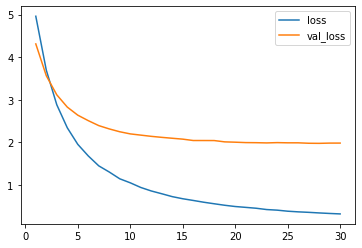

In [14]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

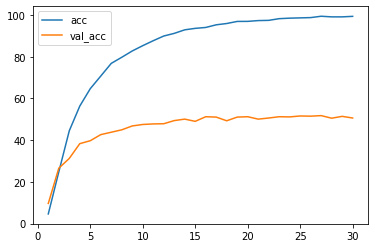

In [15]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

Since we have created checkpoints using callbacks, we can restore the best model from those checkpoints and test it.

In [ ]:
resnet18 = models.resnet18(pretrained=False, num_classes=num_classes)

model = Model(resnet18, 'sgd', 'cross_entropy', batch_metrics=['accuracy'], epoch_metrics=['f1'])

model.to(device)

model.load_weights('best_epoch_{epoch}.ckpt'.format(epoch=best_epoch))

test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}\n\tF1-score: {}'.format(test_loss, test_acc, test_f1))